In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import yaml
import os

In [2]:
# 数据集：
# 'source/1.1'
# 'source/1.2' 不推荐使用 没有正常的模板
# 'source/1.3'

source_path = 'source/1.1'
config_file_path = os.path.join(source_path, 'config.yaml')



In [3]:

def load_specific_config(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        config = yaml.safe_load(file)

    # 提取特定配置项
    image_path = config.get('image', {}).get('path')
    candidate_points = config.get('candidate_points', [])
    zone_point = config.get('scan_zone', {}).get('center_point', [0, 0])
    zone_radius = config.get('scan_zone', {}).get('radius', 0)
    zone_theta = config.get('scan_zone', {}).get('angle', 0)
    valid_threshold = config.get('scan_zone', {}).get('valid_threshold', 0)
    step = config.get('scale', {}).get('step', 5)
    start_point = config.get('scale', {}).get('start', 0.0)
    end_point = config.get('scale', {}).get('end', 0.0)
    precision = config.get('scale', {}).get('precision', 0)
    unit = config.get('scale', {}).get('unit', '')

    return (
        image_path,
        candidate_points,
        zone_point,
        zone_radius,
        zone_theta,
        valid_threshold,
        step,
        start_point,
        end_point,
        precision,
        unit
    )

(
    image_path,
    candidate_point,
    zone_point,
    zone_radius,
    zone_theta,
    valid_threshold,
    step,
    START_POINT,
    END_POINT,
    PRESICISION,
    UNIT
) = load_specific_config(config_file_path)

# 打印提取的配置项以检查是否正确加载
print(f"Image Path: {image_path}")
print(f"Candidate Points: {candidate_point}\n")
print(f"Zone Point: {zone_point}")
print(f"Zone Radius: {zone_radius}")
print(f"Zone Theta: {zone_theta}")
print(f"Valid Threshold: {valid_threshold}")
print(f"step {step}")
print(f"Start Point: {START_POINT}\nEnd Point: {END_POINT}")
print(f"Precision: {PRESICISION}\nUnit: {UNIT}")

Image Path: source/1.1/template2.jpg
Candidate Points: [[700, 766], [624, 659], [603, 528], [647, 403], [745, 311], [851, 276], [981, 292], [1086, 361], [1152, 472], [1160, 601], [1107, 720]]

Zone Point: [974, 350]
Zone Radius: 25
Zone Theta: 10
Valid Threshold: 70
step 5
Start Point: -0.1
End Point: 0.9
Precision: 2
Unit: MPa


In [4]:
img1 = cv2.imread(image_path)
img2 = cv2.imread('source/1.1/img/tv20171228105011CF2FC4.jpg')
candidate_point = np.array(candidate_point)

In [5]:
# 展示图片
def show_img(image):
    # OpenCV 读取的图像是 BGR 格式，而 Matplotlib 显示的是 RGB 格式
    # 因此需要将图像从 BGR 转换为 RGB
    if image is None: print("Error: Unable to load image.")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 使用 Matplotlib 显示图像
        plt.figure(figsize=(12, 12))
        plt.imshow(image_rgb)
        plt.axis('off')  # 关闭坐标轴
        plt.show()

# 绘制点集在图片上 （reversed控制图片坐标系或真实坐标系）
def show_point(image, x_point, y_point, color = (0, 255, 255), coordinate_real=True):
    image_temp = image.copy()
    for (x, y) in zip(x_point, y_point):
        if coordinate_real: cv2.circle(image_temp, (int(x), int(image.shape[1] - y)), 4, color, -1)
        else: cv2.circle(image_temp, (int(x), int(y)), 4, color, -1)
    show_img(image_temp)

In [6]:
from scipy.optimize import least_squares
import numpy as np

def my_fun(parameters, x_samples, y_samples):
    # Unpack parameters: two focus points and the target distance sum
    x_focus_1, y_focus_1, x_focus_2, y_focus_2, sum_of_target_distance = parameters

    # Calculate the actual distances from the points to the two foci
    distance_to_focus_1 = np.sqrt((x_samples - x_focus_1) ** 2 + (y_samples - y_focus_1) ** 2)
    distance_to_focus_2 = np.sqrt((x_samples - x_focus_2) ** 2 + (y_samples - y_focus_2) ** 2)

    # Return the difference between actual and target distances for each point
    return distance_to_focus_1 + distance_to_focus_2 - sum_of_target_distance

def fit_ellipse(x_samples, y_samples):

    # Compute the centroid of the samples
    centroid_x = np.mean(x_samples)
    centroid_y = np.mean(y_samples)

    # Find the point farthest from the centroid
    distances_from_centroid = np.sqrt((x_samples - centroid_x) ** 2 + (y_samples - centroid_y) ** 2)
    max_distance_index = np.argmax(distances_from_centroid)
    far_point_x = x_samples[max_distance_index]
    far_point_y = y_samples[max_distance_index]

    # Initial guess for the second focus
    x_focus_2_init = far_point_x
    y_focus_2_init = far_point_y

    # Estimate the sum of distances from any point on the ellipse to the foci
    sum_of_target_distance_init = 2 * distances_from_centroid[max_distance_index]

    # Optimize to fit the ellipse using initial guesses for the parameters
    initial_guess = np.array([centroid_x, centroid_y, x_focus_2_init, y_focus_2_init, sum_of_target_distance_init])
    res_optimized = least_squares(fun=my_fun, x0=initial_guess, args=(x_samples, y_samples))

    if res_optimized.success:
        # Unpack optimized parameters
        x1_res, y1_res, x2_res, y2_res, l2_res = res_optimized.x

        # Calculate the angle of the ellipse based on the foci
        alpha_res = np.arctan2(y2_res - y1_res, x2_res - x1_res)

        # Calculate the distance between the foci
        l_ab = np.sqrt((y2_res - y1_res) ** 2 + (x2_res - x1_res) ** 2)

        # Calculate semi-major and semi-minor axes
        a_res = l2_res / 2  # Semi-major axis length
        b_res = np.sqrt(a_res**2 - (l_ab / 2)**2)  # Semi-minor axis length

        return a_res, b_res, (x1_res+x2_res)/2, (y1_res+y2_res)/2, alpha_res
    else:
        print('Fail to fit ellipse')
        return None


# (x, y) rotate around (h,k) with alpha
def rotate(x, y, alpha):
    x_rot = x * np.cos(alpha) - y * np.sin(alpha)
    y_rot = x * np.sin(alpha) + y * np.cos(alpha)
    return x_rot, y_rot
def get_Point_in_ellipse(a, b, theta):
    return a * np.cos(theta) , b * np.sin(theta)

def Point_in_ellipse(h, k, a, b, alpha, theta):
    x0, y0 = np.cos(theta), np.sin(theta)
    x_real_rot, y_real_rot = rotate(x0, y0, -alpha)
    x_real_rot, y_real_rot = get_Point_in_ellipse(a, b, np.arctan2(y_real_rot, x_real_rot))
    x_res, y_res = rotate(x_real_rot, y_real_rot, alpha)
    return x_res + h, y_res + k

In [7]:
def SIFT4H(img1, img2, debug):

    # 初始化SIFT检测器
    sift = cv2.SIFT_create()
    # 使用SIFT找到关键点和描述符
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN 参数设计
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)   # 或传递一个空字典

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # 准备计算单应性矩阵的数据
    good_matches = []
    pts1 = []
    pts2 = []

    # 应用比例测试
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.float32(pts1).reshape(-1, 2)
    pts2 = np.float32(pts2).reshape(-1, 2)

    # 获取单应性矩阵
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

    # 绘制匹配结果
    draw_params = dict(matchColor=(0, 255, 0),  # 使用绿色绘制匹配项
                       singlePointColor=None,
                       matchesMask=mask.ravel().tolist(),  # 只绘制内部点
                       flags=2)


    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)

    if not debug: return H
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title('Matches')
    plt.show()

    return H

In [8]:
def save_cv_image_with_plt(cv_image, output_path):
    # 如果图像是彩色的，则将其从BGR转换为RGB
    if len(cv_image.shape) == 3:
        rgb_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    else:
        rgb_image = cv_image  # 灰度图像不需要转换

    # 创建一个新的图形，并关闭坐标轴
    plt.figure()
    plt.axis('off')  # 关闭坐标轴
    plt.gca().set_axis_off()  # 隐藏边框

    # 显示图像
    plt.imshow(rgb_image, cmap='gray' if len(cv_image.shape) == 2 else None)

    # 保存图像到文件，bbox_inches='tight' 和 pad_inches=0 用来去掉边缘空白
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()  # 关闭当前图形以释放内存

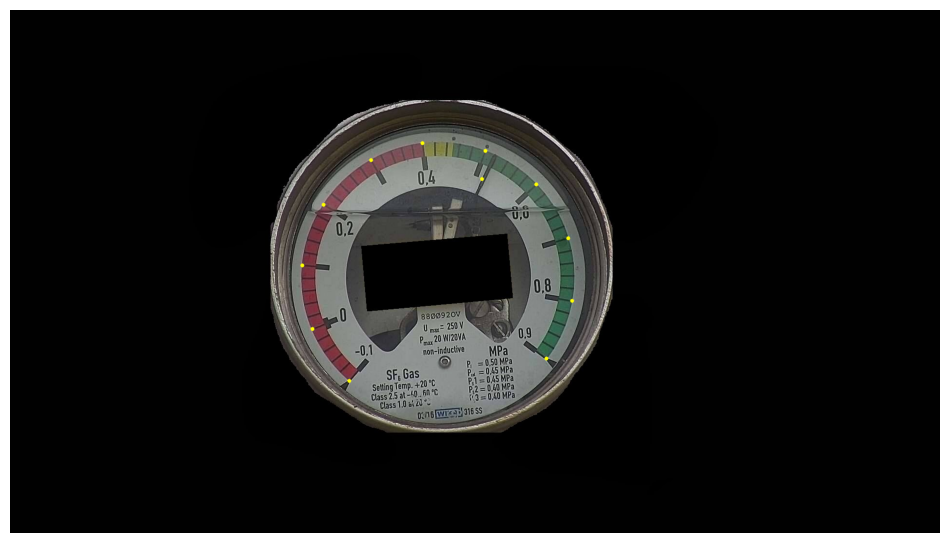

In [9]:
candidate_point = np.vstack((candidate_point, zone_point))

x_samples = candidate_point.T[0]
y_samples = candidate_point.T[1]
show_point(img1, x_samples, y_samples, coordinate_real=False)

In [10]:
# 使用单应矩阵 对点进行转换
# 图像坐标系
def transform_point_with_H(x_point, y_point, H):
    point = np.array([x_point, y_point], dtype=np.float32).T
    projected_points = (cv2.perspectiveTransform(point.reshape(-1,1,2), H).reshape(-1,2).T)
    return projected_points[0], projected_points[1]


def warp_image_and_points_with_H(H, img2, x_point, y_point):
    # 获取img2的尺寸
    height, width = img2.shape[:2]

    # 定义img2四个角点的位置
    corners = np.float32([[0, 0], [0, height], [width, height], [width, 0]]).reshape(-1, 1, 2)

    # 使用perspectiveTransform来找到四个角点变换后的位置
    transformed_corners = cv2.perspectiveTransform(corners, H)

    # 找到变换后的最小外接矩形
    x_min = min(transformed_corners[:, 0, 0])
    y_min = min(transformed_corners[:, 0, 1])
    x_max = max(transformed_corners[:, 0, 0])
    y_max = max(transformed_corners[:, 0, 1])

    # 计算新图像的宽度和高度
    new_width = int(np.round(x_max - x_min))
    new_height = int(np.round(y_max - y_min))

    # 调整H矩阵，使得变换后的图像不被裁剪
    translation_matrix = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float32)
    adjusted_H = np.dot(translation_matrix, H)

    # 应用透视变换到图像
    warped_img2 = cv2.warpPerspective(img2, adjusted_H, (new_width, new_height))

    # 将输入的点转换为正确的格式，并应用相同的变换矩阵
    points = np.array([x_point, y_point], dtype=np.float32).T.reshape(-1, 1, 2)
    transformed_points = cv2.perspectiveTransform(points, translation_matrix).reshape(-1, 2).T
    # 返回变换后的图像和点集
    return warped_img2, transformed_points[0], transformed_points[1]


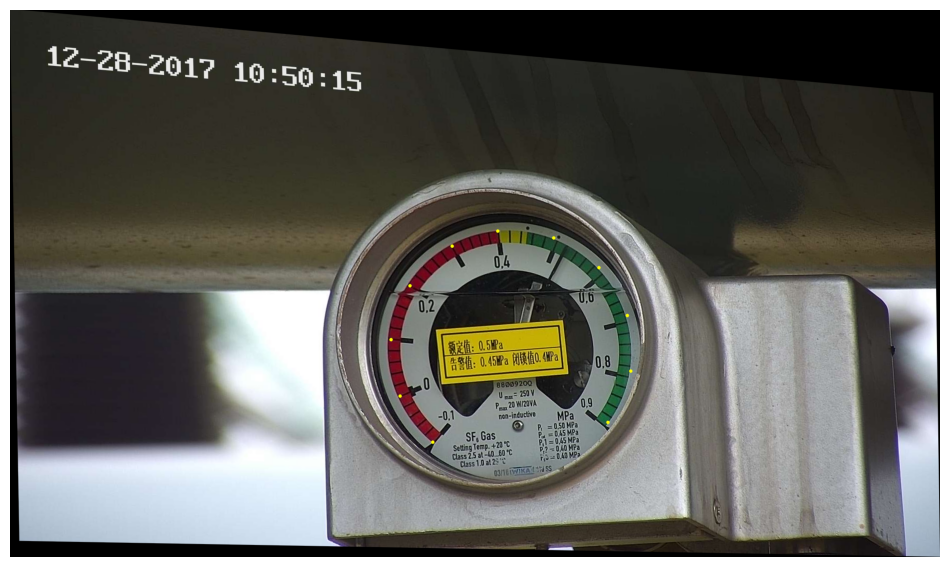

In [11]:
# 对待测图进行矫正 将标注点标注在新的图像上

H_img2_img1 = SIFT4H(img2, img1, False)
work_img, x_img_correct, y_img_correct = warp_image_and_points_with_H(H_img2_img1, img2, x_samples, y_samples)

zone_point_correct = (x_img_correct[-1], y_img_correct[-1])
x_img_correct = x_img_correct[:-1]
y_img_correct = y_img_correct[:-1]

show_point(work_img, x_img_correct, y_img_correct, coordinate_real=False)

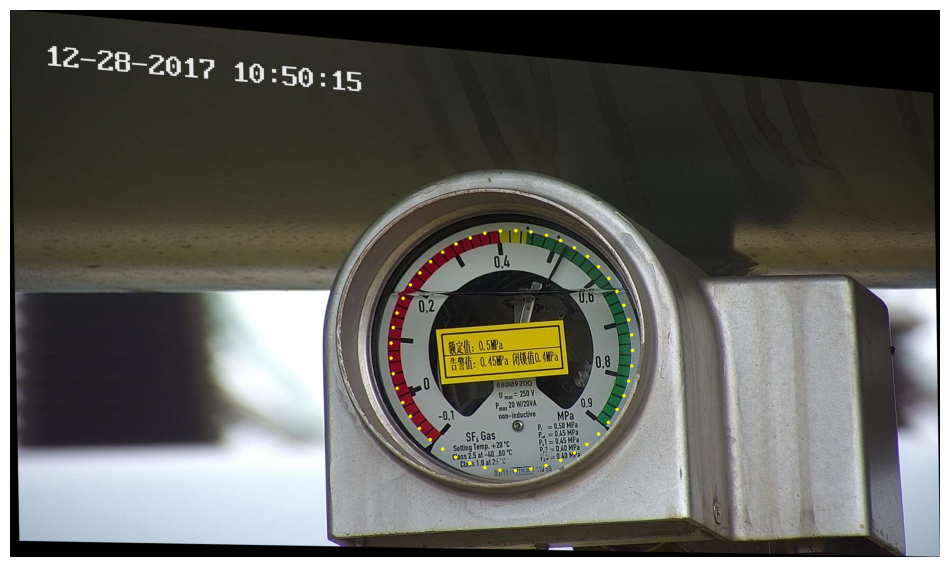

In [12]:
# 求解椭圆
a_res, b_res, x0, y0, alpha_res = fit_ellipse(x_img_correct, y_img_correct)

theta_res = np.linspace(0, 2*np.pi, 50)
x_res, y_res = Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_res)
# 预览 检查椭圆曲线拟合
show_point(work_img, x_res, y_res, coordinate_real=False)

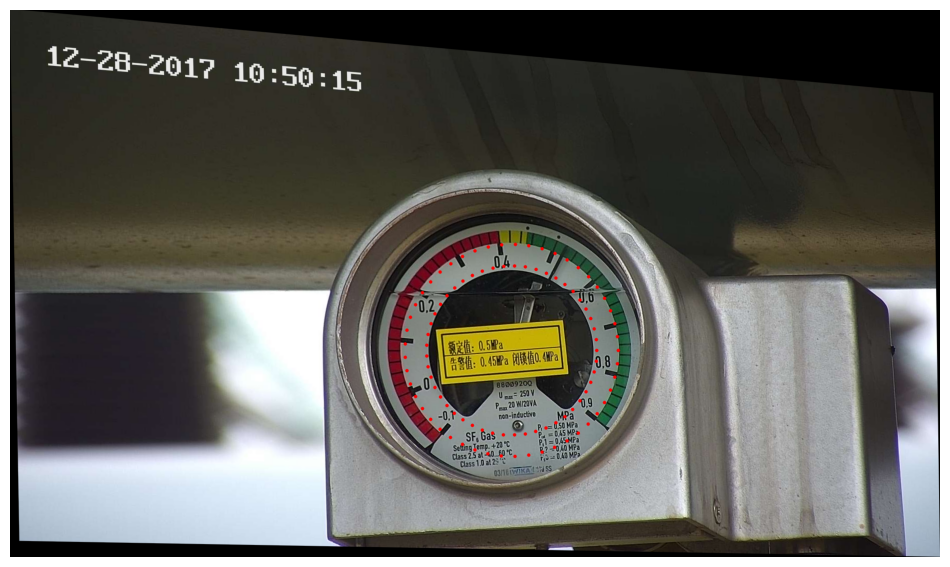

In [13]:
zone_point_x, zone_point_y = zone_point_correct[0], zone_point_correct[1]
zone_vec1 = np.array([zone_point_x, zone_point_y]) - np.array([x0,y0])
zone_vec2 = np.array([x_res[0], y_res[0]]) - np.array([x0,y0])
s = np.linalg.norm(zone_vec1)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
a_zone = a_res * s
b_zone = b_res * s

# 扫描区域可视化
s_l = (np.linalg.norm(zone_vec1)-zone_radius)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
s_r = (np.linalg.norm(zone_vec1)+zone_radius)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
x_zone_l, y_zone_l = Point_in_ellipse(x0, y0, a_res * s_l, b_res * s_l, alpha_res, theta_res)
x_zone_r, y_zone_r = Point_in_ellipse(x0, y0, a_res * s_r, b_res * s_r, alpha_res, theta_res)

show_point(work_img, np.concatenate((x_zone_l, x_zone_r)), np.concatenate((y_zone_l, y_zone_r)), (0, 0, 255), coordinate_real=False)

In [14]:
def mask_and_crop_image(img, a, b, x0, y0, alpha):
    # Create a copy of the image to avoid modifying the original
    img_masked = img.copy()

    # Generate meshgrid for efficient computation
    Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
    cos_alpha = np.cos(alpha)
    sin_alpha = np.sin(alpha)

    # Compute rotated coordinates
    x_rot = (X - x0) * cos_alpha + (Y - y0) * sin_alpha
    y_rot = -(X - x0) * sin_alpha + (Y - y0) * cos_alpha

    # Compute the ellipse equation and create a mask
    ellipse_mask = ((x_rot ** 2) / (a ** 2)) + ((y_rot ** 2) / (b ** 2)) <= 1

    # Apply the mask to the image
    img_masked[~ellipse_mask] = [0, 0, 0]

    # Find bounding box of the non-zero elements in the masked image
    rows = np.any(img_masked, axis=1)
    cols = np.any(img_masked, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]

    # Crop the image using the bounding box
    cropped_img = img_masked[ymin:ymax+1, xmin:xmax+1]

    # Calculate new center coordinates relative to the cropped image
    new_x0 = x0 - xmin
    new_y0 = y0 - ymin

    return cropped_img, new_x0, new_y0

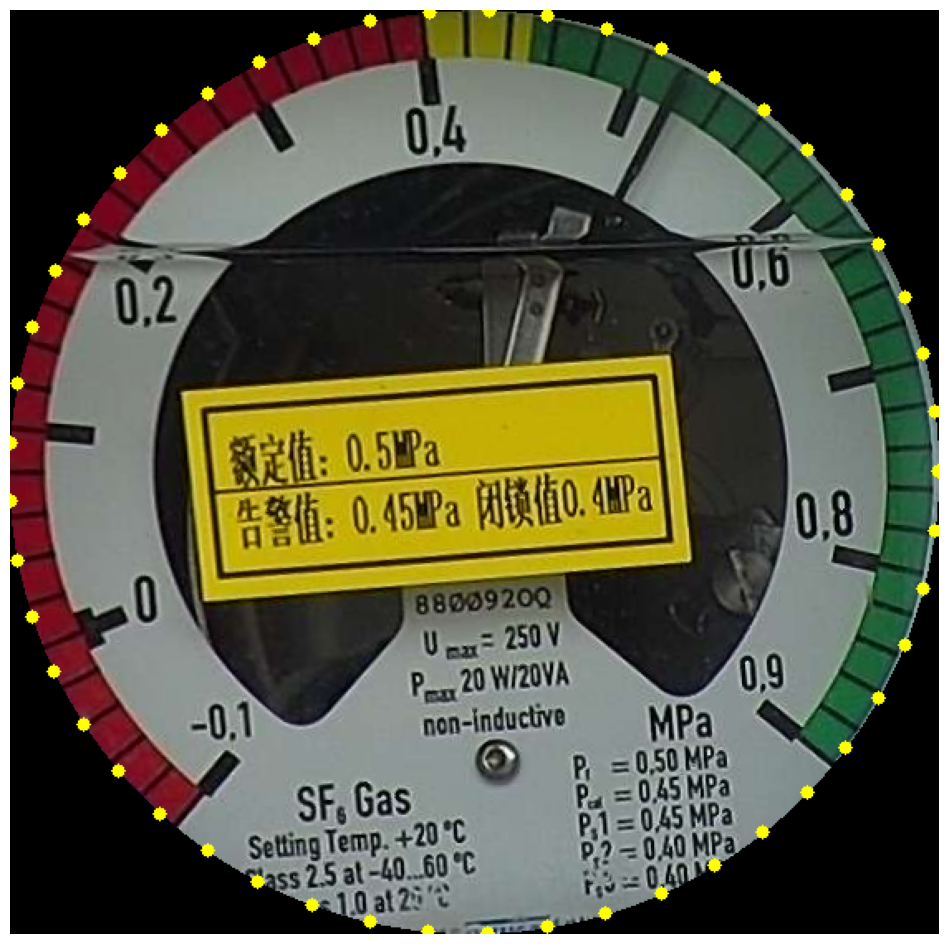

In [15]:
work_img_with_masked, x0, y0 = mask_and_crop_image(work_img, a_res , b_res, x0, y0, alpha_res)
theta_crop = np.linspace(0, 2*np.pi, 50)
x_crop, y_crop = Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_res)
# 预览 检查椭圆曲线拟合
show_point(work_img_with_masked, x_crop, y_crop, coordinate_real=False)

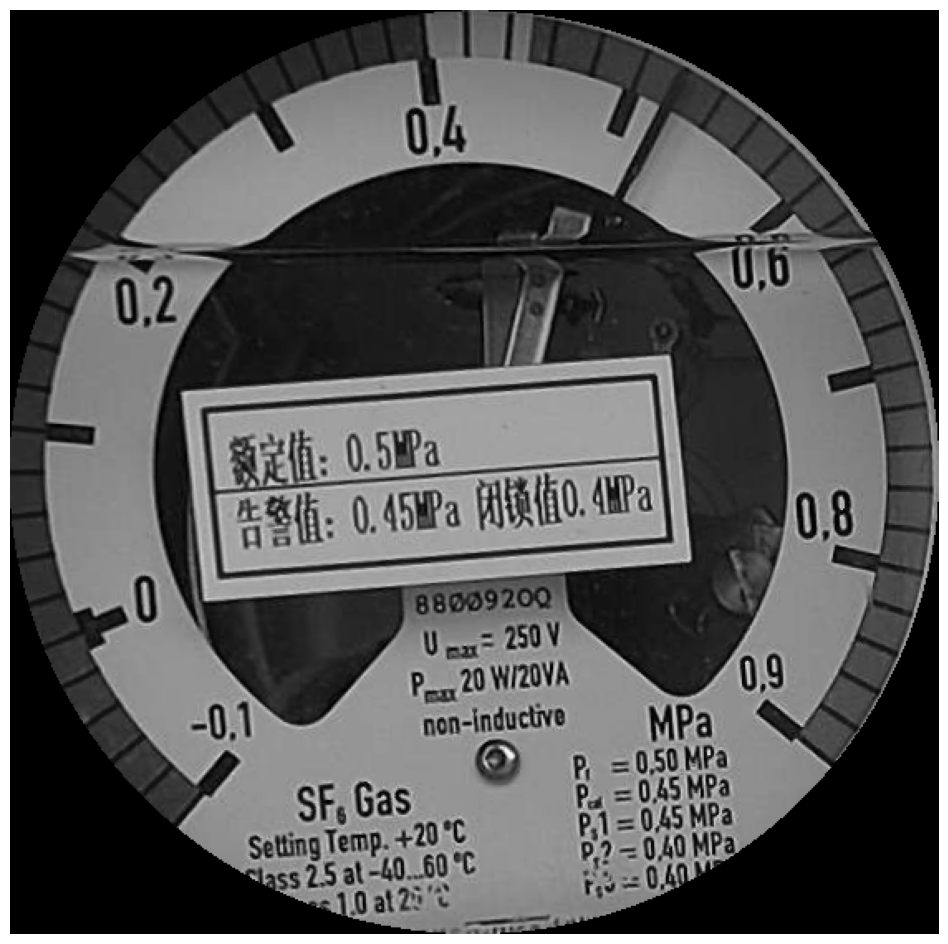

In [16]:
gray_image = cv2.cvtColor(work_img_with_masked, cv2.COLOR_BGR2GRAY)
show_img(gray_image)

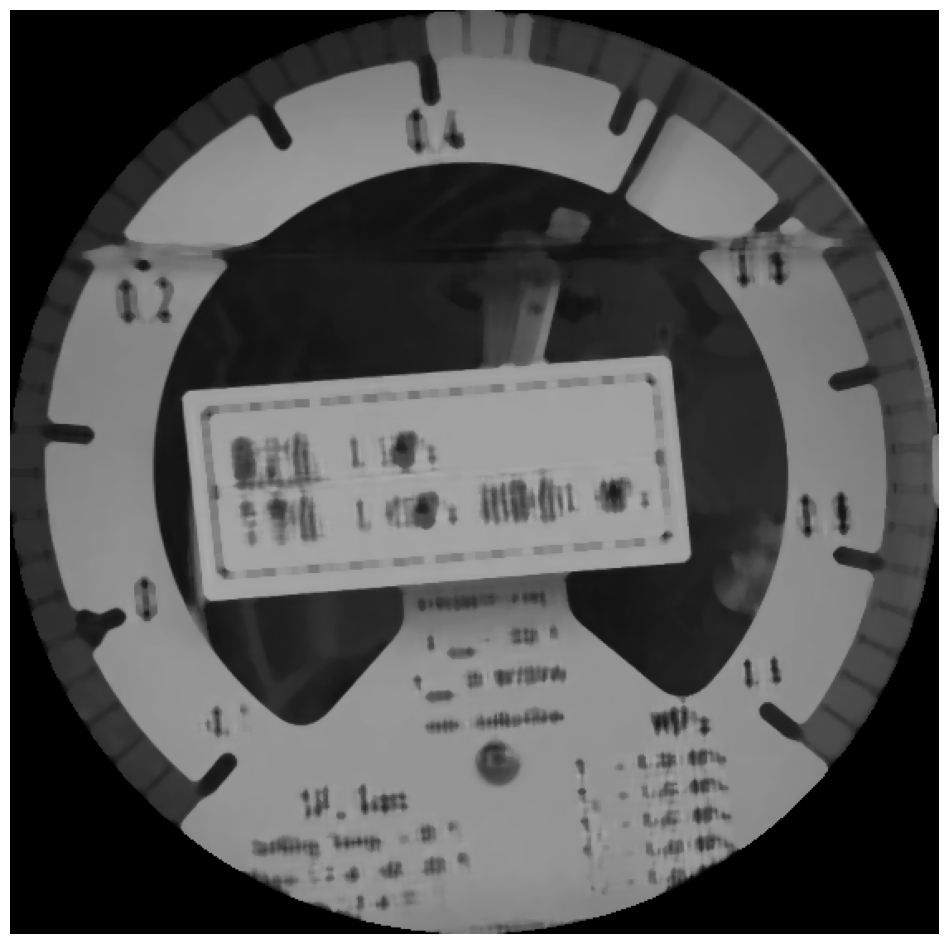

In [17]:
median_filtered_image = cv2.medianBlur(gray_image, ksize=9) # 这里ksize是窗口大小，必须是正奇数
show_img(median_filtered_image)

82.0


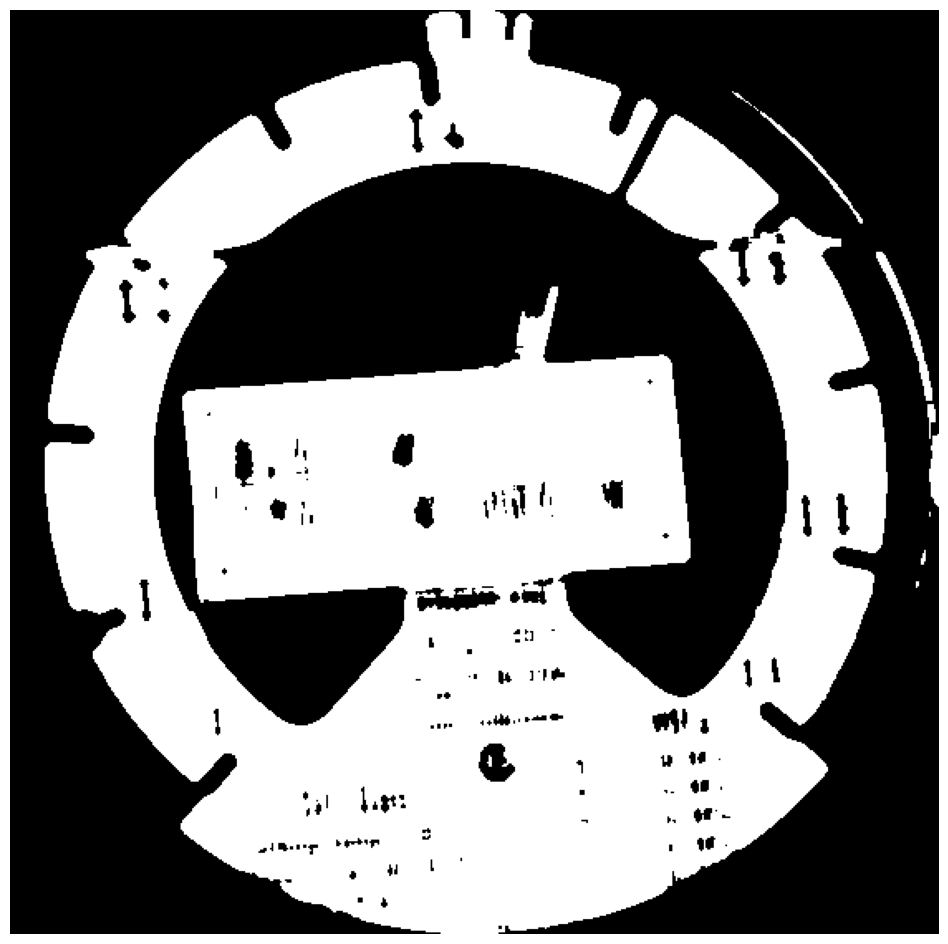

In [18]:
# Otsu's二值化方法 ret是二值化阈值
ret, binary_image = cv2.threshold(median_filtered_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(ret)
show_img(binary_image)

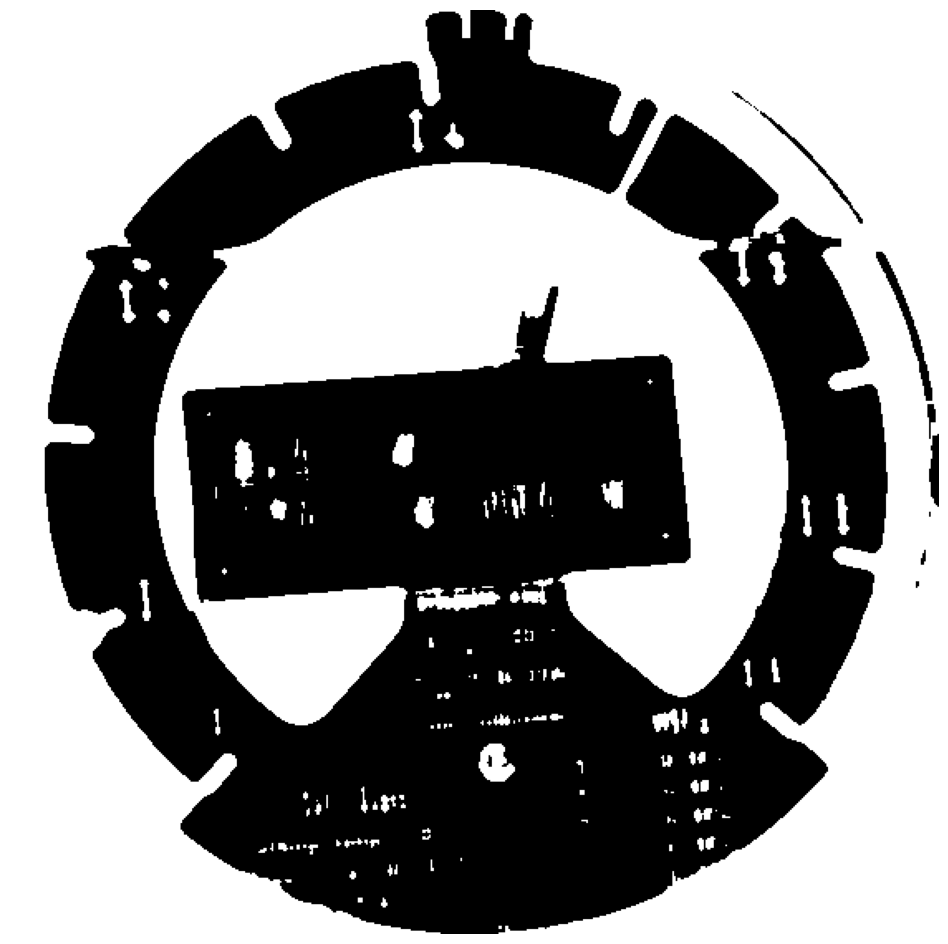

In [19]:
# 反转
inverted_image = 255 - binary_image.copy()
show_img(inverted_image)

save_cv_image_with_plt(inverted_image, 'test1.jpg')

In [20]:
def dilate_image(binary_image, kernel_size=3):
    """
    对二值图像进行膨胀操作。
    :param binary_image: 输入二值图像
    :param kernel_size: 膨胀核的大小，默认为3
    :return: 膨胀后的图像
    """
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_image = cv2.dilate(binary_image, kernel, iterations=1)
    return dilated_image

def erode_image(binary_image, kernel_size=3):
    """
    对二值图像进行腐蚀操作。
    :param binary_image: 输入二值图像
    :param kernel_size: 腐蚀核的大小，默认为3
    :return: 腐蚀后的图像
    """
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_image = cv2.erode(binary_image, kernel, iterations=1)
    return eroded_image



def zhang_suen_thinning_vectorized(binary_image):
    """
    向量化实现 Zhang-Suen 细化算法。
    :param binary_image: 输入二值图像，像素值为 0 或 255
    :return: 细化后的图像
    """
    binary_image = (binary_image // 255).astype(np.uint8)  # 确保输入图像为 0 和 1
    rows, cols = binary_image.shape
    prev_image = np.zeros_like(binary_image)
    diff = True

    # 8 个方向的偏移
    neighbors_offsets = [
        (-1, 0), (-1, 1), (0, 1), (1, 1),
        (1, 0), (1, -1), (0, -1), (-1, -1)
    ]

    while diff:
        prev_image = binary_image.copy()

        # 标记删除的点（第一子迭代）
        marker = np.zeros_like(binary_image, dtype=np.uint8)
        for step in range(2):
            # 计算 8 邻域
            neighbors = [
                np.roll(np.roll(binary_image, dy, axis=0), dx, axis=1)
                for dy, dx in neighbors_offsets
            ]
            # 条件 A: 从 P2 到 P9 的 0->1 转变次数
            transitions = sum((neighbors[i - 1] == 0) & (neighbors[i] == 1) for i in range(8))
            # 条件 B: 8 邻域白色像素总数
            neighbor_sum = sum(neighbors)
            # 条件 C: P2 * P4 * P6 和 P4 * P6 * P8 检查
            if step == 0:
                C1 = neighbors[0] * neighbors[2] * neighbors[4]
                C2 = neighbors[2] * neighbors[4] * neighbors[6]
            else:
                C1 = neighbors[0] * neighbors[2] * neighbors[6]
                C2 = neighbors[0] * neighbors[4] * neighbors[6]

            # 综合条件
            marker = marker | ((binary_image == 1) &
                               (2 <= neighbor_sum) & (neighbor_sum <= 6) &
                               (transitions == 1) &
                               (C1 == 0) & (C2 == 0))
            # 删除标记的点
            binary_image[marker] = 0

        # 检查是否有变化
        diff = not np.array_equal(binary_image, prev_image)

    return (binary_image * 255).astype(np.uint8)


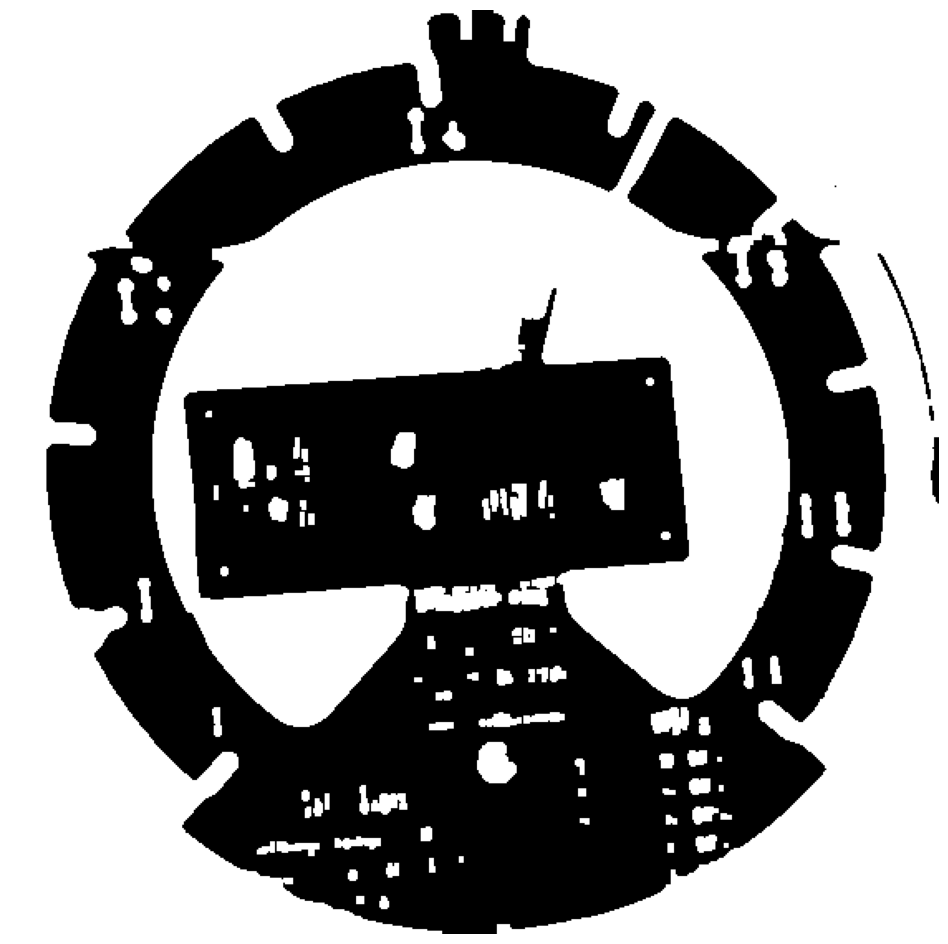

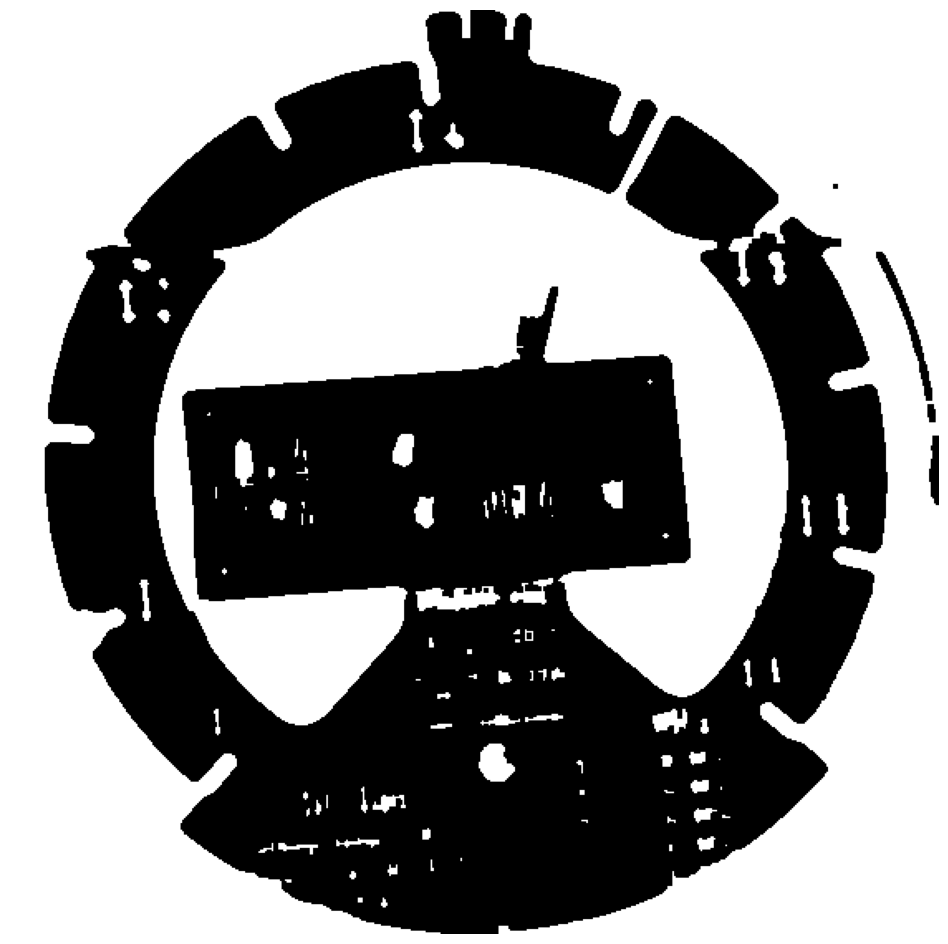

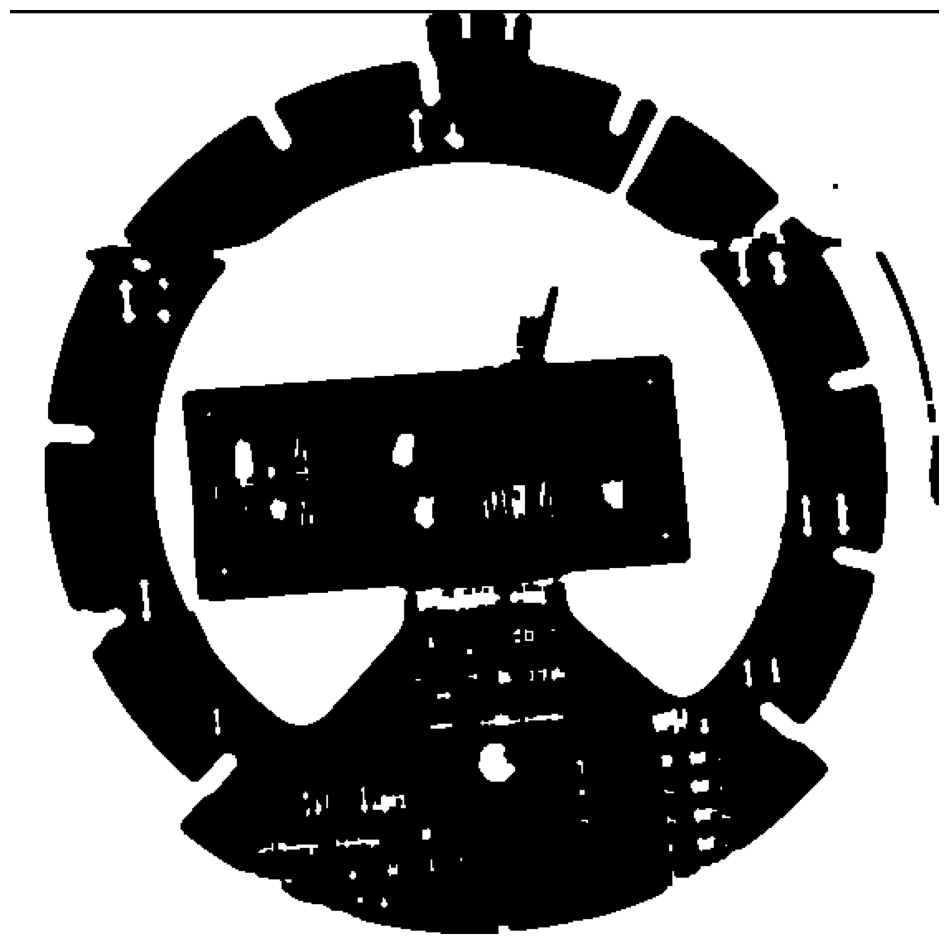

In [21]:

# 膨胀
dilated = dilate_image(inverted_image)

show_img(dilated)
# 腐蚀
eroded = erode_image(dilated)

show_img(eroded)
# 细化
thinned_image = zhang_suen_thinning_vectorized(eroded)
show_img(thinned_image)


# save_cv_image_with_plt(eroded, 'test2.jpg')

In [22]:
print(cv2.__version__)

4.10.0
